# If matrices are dictionaries, the inner product is a (sexy) secretary

Welcome back to another episode of hand-waving. This time around, we'll make use of those handy-dandy inner products to do some cool stuff: generate signals, find signals, and computing stuff using einsum. we'll have to recall a couple of things as we go along, but we'll worry about that when it happens. Let's roll!

---

## Matrices as dictionaries

It's time to play around with some **energy signals**. These are signals that are square integrable, meaning

$$
\int_{-\infty}^{\infty} \vert f(t) \vert ^2 dt = \int_{-\infty}^{\infty} f^*(t) f(t) dt < \infty.
$$

In simpler terms, we can compute the squared magnitude of $f(t)$ using an inner product the way we discussed last time. The term **energy signal** comes from signals and systems: Florian will tell us all about it in the near future :P. Let's check out a simple **rectangular** function $r_T(t)$. We'll define it ourselves as follows.


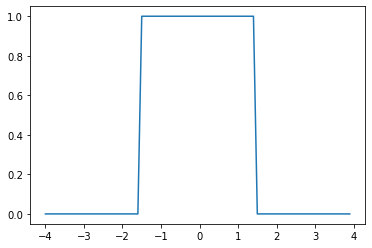

In [1]:
'''
Don't worry about how the function is defined! Look at the plot!
By the way, this is a good point to brush up our documentation practices
:3 Don't forget to comment everything!
'''

import numpy as np
import matplotlib.pyplot as plt

def rect(t, T):
    r'''
    Rectangular function. Given a domain and a duration, a vector containing 
    samples of the corresponding rect function is returned. Symmetric 
    around t = 0.
    
    INPUT:
        t: time domain samples at which the rectangle function is evaluated
        T: total duration of the rect function; extends T/2 to each side
    
    OUTPUT:
        r: vector of size N = len(t) containing the specified rect function
    '''
    
    return (np.abs(t)/T <= 0.5)

#let's test it out!
dt = 0.1 #sampling rate
t = np.arange(-4, 4, dt) #time domain
T = 3 #duration of the pulse
r = rect(t, T) #signal

plt.plot(t, r)

All righty. We've defined this rect function that has a total time duration of $T$ and is centered at $t = 0$. We'll play around with this for a while. Let's set $dt = 1$ and take a rect function with a duration of $T = 3$. With these parameters, we're essentially saying that the pulse will have 3 non-zero samples. We will be using $N = 10$ samples so that things are easy to visualize as we go along, and we'll only be using non-negative time values, i.e. $0 \leq t < N$. Let's play around by generating a few shifted copies of $r(t)$. 

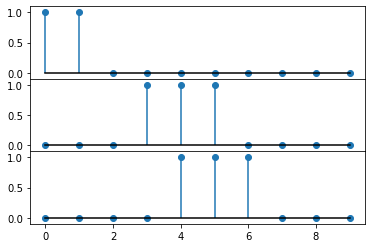

In [2]:
#let's put all our parameters here:
dt = 1 #sampling rate
T = 3 #pulse duration
N = 10 #number of samples
t = np.arange(0, N*dt, dt) #time axis

#first pulse
k1 = 0 #no delay
r1 = rect(t - k1, T)

#second pulse
k2 = 4
r2 = rect(t - k2, T)

#third
k3 = 5
r3 = rect(t - k3, T)

#and now, we plot
ax1 = plt.subplot(3,1,1) #3 vertically aligned subplots
plt.stem(t, r1, basefmt="k-") #last param removes red baseline
plt.setp(ax1.get_xticklabels(), visible=False) #hide x ticks
plt.ylim([-0.1,1.1]) #makes it easier to see the plots well

ax2 = plt.subplot(3,1,2, sharex = ax1) #share x axis
plt.stem(t, r2, basefmt="k-") #plot w/o baseline
plt.setp(ax2.get_xticklabels(), visible=False) #hide x ticks
plt.ylim([-0.1,1.1]) #makes it easier to see the plots well

plt.subplot(3,1,3, sharex = ax1) #share x axis
plt.stem(t, r3, basefmt="k-") #plot w/o baseline
plt.ylim([-0.1,1.1]) #makes it easier to see the plots well

plt.subplots_adjust(hspace=.0) #remove vert. space between subplots

By now you must be wondering where we're even going with this. Well, check this out. Let's give the signals some arbitrary amplitude and add them up:

<StemContainer object of 3 artists>

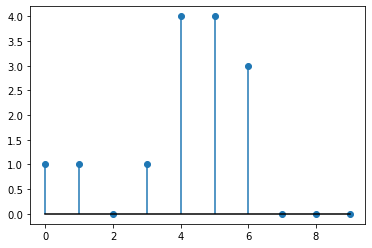

In [3]:
g = 1*r1 + 1*r2 + 3*r3 #add up the signals
plt.stem(t, g, basefmt="k-")

What have we done here? Well, we can rewrite this as

$$
\boldsymbol{g} = 1\boldsymbol{r}_1 + 1\boldsymbol{r}_2 + 3\boldsymbol{r}_3.
$$

Look familiar? The vector $\boldsymbol{g}$ is a **linear combination** of the $\boldsymbol{r}_i$ vectors. Coincidentally, this is also the definition of a matrix-vector product when we look at a matrix that is defined columnwise. Let's refresh our memory a little. The $\boldsymbol{r}_i$ vectors can be collected into a matrix $\boldsymbol{A}$ and their amplitudes can be put into a vector $\boldsymbol{x}$. We can then express this more compactly as 

$$
\boldsymbol{g} = [\boldsymbol{r}_1 \, \boldsymbol{r}_2 \, \boldsymbol{r}_3]
\begin{bmatrix}
1 \\
1 \\
3
\end{bmatrix} = \boldsymbol{Ax}.
$$

Seen like this, we can interpret the column representation of matrices as follows: 
* *A matrix is like a dictionary or a menu. Vectors pick out entries from this dictionary/menu and put them all together.*

We can exploit this idea as follows. Imagine you want the possibility of adding up any arbitrary amount of shifted copies of $r(t)$, with any shift (**Disclaimer: shifts that we can get as multiples of** $dt$) and any amplitude. We could construct a different dictionary $\boldsymbol{A}_j$ for each $\boldsymbol{g}_j$ we desire, but we can do better than that. What we can do is collect all the possible $r(t-k)$ in our desired domain into a matrix. In this example, we had set $N = 10$ and $0 \leq t < N$. The possible time delays are also in this domain, so $0 \leq k < N$. Since our step size is $dt = 1$, we get $k \in \{1, 2, \dots, 9 \}$, and so we have 10 possible versions of $r(t-k)$. Each one of these shifted copies will have $N = 10$ samples, and so we will end up with an $N \times N$ matrix. Let's construct it and see what we get!

In [4]:
#just so that we don't have to scroll up, let's 
#bring over the parameters:
dt = 1
T = 3
N = 10
t = np.arange(0, N*dt, dt)

#now, we build our matrix A with a for loop:
A = np.zeros((N,N)) #initialize the matrix to save time

for k in range(N): #iterate over the columns
    #remember! each column corresponds to a different shift!
    A[:, k] = rect(t - k, T)

#just for completeness, we can also do this more quickly with
#list comprehension as follows:
B = [rect(t - k, T) for k in range(N)]
B = np.array(B) #turn the list into a numpy array
#IMPORTANT! Tt doesn't matter in this particular example, but
#what we did here puts the vectors as the ROWS of the matrix
#B! We have to transpose it!!!
B = B.T #transpose

#lazy way of showing the two matrices are identical
print(A == B)

[[ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]]


Awesomesauce, we have our matrix. Now, let's plot it and take a look!

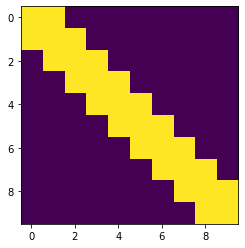

In [5]:
plt.imshow(B)

Well, lookie here. This is a **Toeplitz** matrix: the diagonals of the matrix are constant. What's more, **all 1-D dictionary matrices built this way have a Toeplitz structure**. We can take advantage of this, since a square $N \times N$ Toeplitz matrix only needs $2N$ samples to be completely described.

**This is a hint as to how to make memory-friendly code, BTW, though it's more complicated in higher dimensions.**

<StemContainer object of 3 artists>

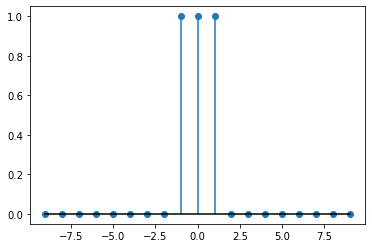

In [6]:
'''
Let's roll. What we'd like to do is define the Toeplitz matrix using only the
promised 2N samples. 2N - 1, actually. The way to do this is by taking our
function r(t) and evaluating it from -(N-1) to (N-1) instead of the original
0 to (N-1).
'''

#params, once again
dt = 1
N = 10
T = 3

#this is new, though:
t = np.arange( -(N-1)*dt, N*dt, dt) #remember np.arange excludes the upper bound!

#make our long vector without any shifts (centered at 0):
r = rect(t, T)

#plot it, because why not?
plt.stem(t, r, basefmt="k-")

[[ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]]


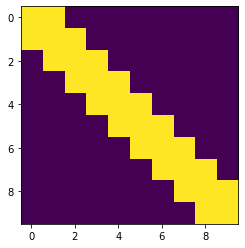

In [7]:
'''
And now use scipy.linalg to make a Toeplitz matrix as follows:

In a Toeplitz matrix, each column can be obtained by shifting the previous one
down by one sample. This means that at each column, the last sample is lost,
and a new sample is needed so that we can put it at the beginning. Due to this,
a Toeplitz matrix is defined by its first column (since it is used to define the
following columns by shifting it), and its first row (since the first row has all
of these new samples that have to be added in after shifting).
'''
column1 = r[N-1:] #all samples from N-1 until the end; i.e., the second half of r(t)
row1 = r[0:N] #all samples from 0 until N-1 (last sample ignored by slice notation)
row1 = np.flipud(row1) #important! we have to REVERSE the first half of the signal!
#the idea is that we should be able to see this long signal r(t) that goes from
#-(N-1) to (N-1) if we start reading the samples from the END of row1 back until its
#start, and then we continue from the START of column1 and go on until its end.

import scipy.linalg as slin

A = slin.toeplitz(column1, row1)

#and now we check if it's really equal:
print(A == B)

plt.imshow(A)

Nice! We have our dictionary matrix $\boldsymbol{A}$ that will allow us to get any **superposition** of shifted, scaled versions of $r(t - k)$ simply by multiplying by the appropriate vector $\boldsymbol{x}$. Let's test this out! If we go back to our previous setup, we had the shifts $k \in \{0, 4, 5 \}$ with corresponding amplitudes $a \in \{1, 1, 3 \}$. Our new vector $\boldsymbol{x}$ has to account for ALL possible shifts $k$ now, and so $\boldsymbol{x} \in \mathbb{R}^N$ with $N = 10$. This means

$$
\boldsymbol{g} = \boldsymbol{Ax} = \boldsymbol{A}
\begin{bmatrix}
1 \\ 0 \\ 0 \\ 0 \\ 1 \\ 3 \\ 0 \\ 0 \\ 0 \\ 0
\end{bmatrix}
$$

Let's give this a shot!

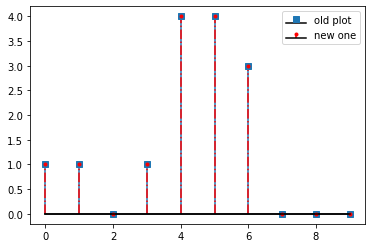

In [8]:
dt = 1
N = 10
T = 3
t = np.arange(0, N*dt, dt)
x = np.array([1,0,0,0,1,3,0,0,0,0])
g_new = A.dot(x)

plt.stem(t, g, markerfmt='s', basefmt="k-")
plt.stem(t, g_new, 'r-.', markerfmt='r.', basefmt="k-")
plt.legend(('old plot','new one'))

So now that we have our fancy dictionary $\boldsymbol{A}$, we can generate different signals $\boldsymbol{g}$ by simply modifying $\boldsymbol{x}$, which is pretty cool! 

---

## The inner product is a secretary

We've done this in the *forward* direction now. This dictionary matrix $\boldsymbol{A}$ was used as our so-called *forward model* that takes the vector $\boldsymbol{x}$ and spits out a signal $\boldsymbol{g}$. We now want to do this in the opposite direction, or in other words, solve the *inverse problem*. We start with a signal $\boldsymbol{g}$ and use our knowledge of the dictionary $\boldsymbol{A}$ to get back to $\boldsymbol{x}$. One way to do this is to just straight up invert the matrix so that

$$
\boldsymbol{x} = \boldsymbol{A}^{-1} \boldsymbol{g}.
$$

We can test this out really quick.

In [9]:
import numpy.linalg as nlin
b=nlin.inv(A).dot(A.dot(x))
print(b)

[1. 0. 0. 0. 1. 3. 0. 0. 0. 0.]


Seems about right. **HOWEVER**. Sometimes it's super difficult to invert the matrix due to several reasons:
* The matrix is large, meaning it's easier to do an iterative algorithm
* The matrix is so large it can't be stored at all in the first place
* The matrix might not be invertible, leaving us to choose one of many possible solutions
* Other reasons I didn't bother with :P

So what else can we do? Well, we can resort to inner products as a secretary that answers the question *where in* $\boldsymbol{g}$ *are copies of* $r(t)$ *located?* Recall the **Cauchy-Schwarz** inequality: 

$$
\boldsymbol{a}^{\text{T}} \boldsymbol{b} \leq \Vert \boldsymbol{a} \Vert_2 \Vert \boldsymbol{b} \Vert_2 \cos{\theta}
$$

An inner product will be maximum when the two vectors are as similar as possible. We could then take our signal $\boldsymbol{g}$ and compare it against all the possible shifted copies of $r(t)$. We can put each of these comparisons as elements of a vector that looks sort of like

$$
\begin{bmatrix}
[r(t)]^{\text{T}} \boldsymbol{g} \\ [r(t-1)]^{\text{T}} \boldsymbol{g} \\ \vdots \\ [r(t-(N-1))]^{\text{T}} \boldsymbol{g}
\end{bmatrix}
=
\begin{bmatrix}
[r(t)]^{\text{T}} \\ [r(t-1)]^{\text{T}} \\ \vdots \\ [r(t-(N-1))]^{\text{T}}
\end{bmatrix} \boldsymbol{g}
=
\begin{bmatrix}
\boldsymbol{r}_0^{\text{T}} \\ \boldsymbol{r}_1^{\text{T}} \\ \vdots \\ \boldsymbol{r}_{N-1}^{\text{T}}
\end{bmatrix} \boldsymbol{g}
.
$$

All righty, so this operation will take a bunch of inner products and tell us how large they are. The places with largest inner products should give is *SOME* idea of where the pulses were in the signal. But let's take a step back and look at what we just wrote. That transpose can be taken out of the matrix and applied to each one of the vectors. This essentially turns each of the $\boldsymbol{r}_i$ vectors into columns of a matrix. And which matrix would that be? Well... a matrix with $\boldsymbol{r}_i$ as columns is exactly the dictionary $\boldsymbol{A}$ we started with! That is to say, 

$$
\begin{bmatrix}
\boldsymbol{r}_0^{\text{T}} \\ \boldsymbol{r}_1^{\text{T}} \\ \vdots \\ \boldsymbol{r}_{N-1}^{\text{T}}
\end{bmatrix} \boldsymbol{g} 
= 
[\boldsymbol{r}_0 \, \boldsymbol{r}_1 \, \dots \, \boldsymbol{r}_{N-1}]^{\text{T}} \boldsymbol{g}
=
\boldsymbol{A}^{\text{T}} \boldsymbol{g}
.
$$

Oho! we can get an idea of how $\boldsymbol{x}$ looks simply by using $\boldsymbol{A}^{\text{T}}$ instead of $\boldsymbol{A}^{-1}$! It won't work perfectly, **and in some scenarios it won't work AT ALL**, but it's MUCH faster than inverting the dictionary matrix (if this can even be done at all). We denote this as $\hat{\boldsymbol{x}}$, our **estimate** of the true $\boldsymbol{x}$, and we get it as

$$
\hat{\boldsymbol{x}} = \boldsymbol{A}^{\text{T}} \boldsymbol{g}.
$$

Now, let's give this a shot and see what happens.

<StemContainer object of 3 artists>

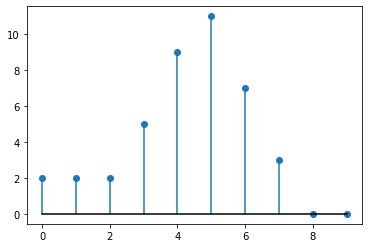

In [10]:
x_hat = A.T.dot(g)
plt.stem(t, x_hat, basefmt="k-")

As stated earlier, it won't always work. The shifts are too close to each other for us to be able to estimate them in this simple way. Let's look an easier scenario and give it another try.

<StemContainer object of 3 artists>

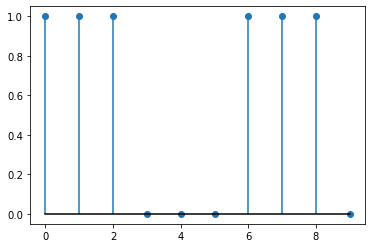

In [11]:
x = np.array([0,1,0,0,0,0,0,1,0,0])
g = A.dot(x)

plt.stem(t, g, basefmt="k-")

And now we try to get $\hat{\boldsymbol{x}}$ back using the transpose.

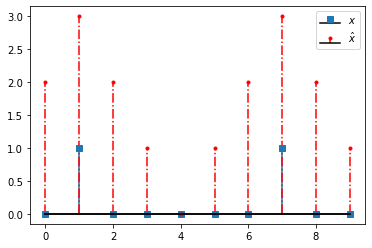

In [12]:
x_hat = A.T.dot(g)
plt.stem(t, x, markerfmt='s', basefmt="k-")
plt.stem(t, x_hat, 'r-.', markerfmt='r.', basefmt="k-")
plt.legend(('$x$', '$\hat{x}$'))

Would you look at that beauty. We're able to find the non-zero elements of $\boldsymbol{x}$ simply by finding the **peaks** in $\hat{\boldsymbol{x}} = \boldsymbol{A}^{\text{T}} \boldsymbol{g}$. As you might notice, the amplitudes aren't quite right though. The amplitudes are a different issue that we'll leave for another time. 

As a recap: Say we have a signal that contains scaled and shifted copies of some waveform. We can put the shifted copies of the waveform into a dictionary matrix $\boldsymbol{A}$ to easily generate signals of this kind. In this dictionary, the shifted copies are **columns**. If we now set the shifted copies as **rows** of a matrix, we get $\boldsymbol{A}^{\text{T}}$. Multiplying the signal by this transposed dictionary gives us the inner product of the signal with every single one of the possible shifts. Waving our hands wildly, the resulting vector $\hat{\boldsymbol{x}}$ has a high amplitude at locations where the pulses are (likely) found... as long as the signal was *nice* in some sense.

---

## Some sweet implementations!

So now we know that we can create signals containing shifted, scaled copies of some pulse shape by multiplying a dictionary matrix with a vector. We can rewrite this as

$$
g[n] = \sum_{d=1}^D a_d p[n - k_d] = \boldsymbol{Ax},
$$

where $D$ is the so-called **model order** (the number of pulses in the signal), $a_d$ is the amplitude of the $d$th pulse, the pulse shape is described by $p[n]$, and the shift is given by $k_d$. Just keep this in the back of your head whenever you think of problems of this kind :P we might just learn more about it in the future. Now, onto some other cool stuff. We've learned that in this 1-D case, the dictionary has a Toeplitz structure. Additionally, there is more than one way to think about matrix-vector products and how they are carried out. We will use these two bits of info to come up with some nifty ways of computing $\boldsymbol{g} = \boldsymbol{Ax}$ and $\hat{\boldsymbol{x}} = \boldsymbol{A}^{\text{T}} \boldsymbol{g}$.

### Einstein notation / Einstein summation convention / Einsum

This one's here by popular demand. I will start with a word of caution, though. As you will see shortly, this is a compact representation of operations we are used to. It's quite natural and makes writing code easier. In **SOME** cases it can make code faster and save us a few "for" loops here and there, since it extends to multiple dimensions quite nicely. This means we can work not only with matrices, but with more general **multi-dimensional arrays**. It has drawbacks, though:

* The arrays need to fit in working memory. Using einsum will **NOT** help save memory in any way. If the array cannot fit into memory, we have to split it up into smaller parts, which inevitably introduces some sort of iterative procedure (such as for loops).
* Need I say more? Already, the memory issue means that large matrices cannot be easily used in a GPU nor in RAM in real world scenarios. Our sample FMC and SA data sets require more than 100GB of memory to be processed if one wants to store the whole array.

In short, einsum is a notation formalism that can help remove loops from code. Removing loops can **sometimes** speed up code (NOT always the case, depends on the size of the arrays!). One has to be able to discern when to use it, it's not a magic bullet that slays all multiplication tasks. You've been warned!

With that out of the way, what even IS einsum? Well, let's revisit matrix-vector multiplication yet again. Let's say we have our generic $\boldsymbol{g} = \boldsymbol{Ax}$ setting. We can express this as

$$
\begin{bmatrix}
g_1 \\ g_2 \\ \vdots \\g_N
\end{bmatrix}
=
\begin{bmatrix}
\boldsymbol{a}_1^{\text{T}} \boldsymbol{x} \\ \boldsymbol{a}_2^{\text{T}} \boldsymbol{x} \\ 
\vdots \\ \boldsymbol{a}_N^{\text{T}} \boldsymbol{x}
\end{bmatrix}
=
\begin{bmatrix}
\sum_{j=1}^N a_{1,j} x_j \\ \sum_{j=1}^N a_{2,j} x_j \\ 
\vdots \\ \sum_{j=1}^N a_{N,j} x_j
\end{bmatrix},
$$

where each of the inner products has been expanded into a sum. Let's focus now on the $i$th component of $\boldsymbol{g}$, which is

$$
g_i = \sum_{j=1}^N a_{i,j} x_j.
$$

Now, we already know that we're dealing with multi-dimensional arrays: vectors, matrices, and higher order stuff. There's no need to write the sum because in all of these expressions with inner products, the sum is carried out over the dimensions that have the same index. Look at the sum above: we're adding up over the index $j$. For the matrix, this iterated over the columns. For the vector, it went over the rows. If we're aware of this, there is no need to write out the sum explicitly. Anything with repeated indices is summed over. The Einstein notation for this expression is then

$$
g_i = a_{i,j} x_j.
$$

You see this hasn't really changed how we compute the product AT ALL. It's just very compact, and probably eerie for anyone that hasn't gotten used to it yet. The advantage is notational compactness. For instance, in order to compute $\hat{\boldsymbol{x}} = \boldsymbol{A}^{\text{T}} \boldsymbol{g}$, we need the transpose of the dictionary. In Einstein notation, we get a transpose simply choosing the indices so that now the column index of $a$ matches the index of $g$, and that's all. We then get

$$
\hat{x}_i = a_{j,i} g_j.
$$

That's... about it, really. If you have more dimensions, you get more indices. For now, let's test this 1-D case out.

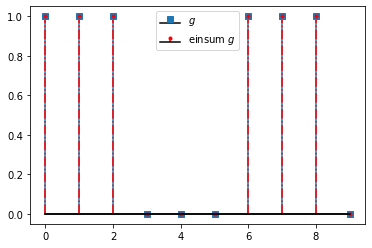

In [13]:
#we already have all our variables, let's roll
g_einsum = np.einsum('ij,j->i', A, x) #the notation is 'indicies of first array, indices of second array -> indices of result'
x_hat_einsum = np.einsum('ji,j->i', A, g) #as stated above, swap out the ij indices of the matrix

#and now we plot and compare
plt.stem(t, g, markerfmt='s', basefmt="k-")
plt.stem(t, g_einsum, 'r-.', markerfmt='r.', basefmt="k-")
plt.legend(('$g$', 'einsum $g$'), loc='upper center')

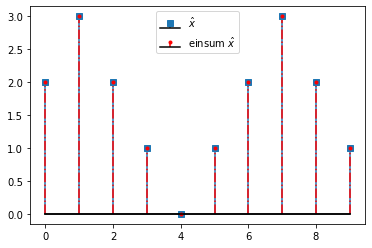

In [14]:
#now the transpose:
plt.stem(t, x_hat, markerfmt='s', basefmt="k-")
plt.stem(t, x_hat_einsum, 'r-.', markerfmt='r.', basefmt="k-")
plt.legend(('$\hat{x}$', 'einsum $\hat{x}$'), loc='upper center')

### Structure exploitation

Now THIS is the good stuff. It can't always be done, but as it turns out, we can do this in many applications related to what we do. As mentioned earlier, a Toeplitz matrix only has $2N - 1$ unique entries, even though the whole matrix has $N^2$ elements. We made use of this to generate a Toeplitz matrix directly from those unique entries. However, there is actually no need to build the matrix in the first place. Hear me out. I know it seems kind of counterintuitive, but this is a case where we would actually PREFER putting in a for loop. Imagine we're working with a Toeplitz matrix for which $N = 100000$, and the matrix contains floats, each using up 64 bits or 8 bytes. The full Toeplitz matrix would require $100000^2 * 8$ bytes, or 80GB of work memory (RAM on a computer or VRAM on a GPU). Yikes! How about if we only use the samples we need? Well, $2 * 100000 * 8$ bytes is 0.0016GB. That's pretty hot stuff. Of course, throwing in a loop is going to make the code run slower. The thing is, the original code with the Toeplitz matrix couldn't run at all. Let's give this a shot and see how it goes. 

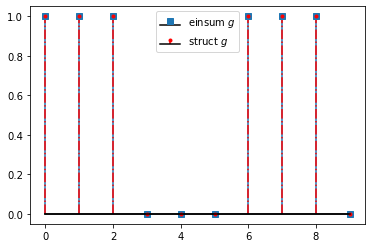

In [15]:
#let's go ahead and build up our long vector r again
dt = 1
T = 3
N = 10
#use a different name for this "long time" so that we can recycle the old variable t
t_long = np.arange(-(N-1)*dt, N*dt, dt)
r_long = rect(t_long, T)

'''
Now, multiply using list comprehension. We have to do two things here. First,
we will slide down the vector by starting at N-1 and going down all the way to
the last (2N-2) sample. At each position, we will take the N samples before,
along with the current one, and put them in a vector. This means that we first
look at the first half of the vector r_long, and slowly make our way to the end.
Next, we reverse the order of this vector. Once this is done, all we have to do
is take the inner product with x (which wasn't defined here, we just carry it 
over from the previous examples). Each element in the resulting vector g is 
simply the inner product of a reversed chunk of r_long with x. Remember to turn 
the list into a numpy array at the end!
'''

g_struct = [np.flipud(r_long[0+k:N+k]).dot(x) for k in range(N)]
g_struct = np.array(g_struct) #make into numpy array

#and now we plot for comparison
plt.stem(t, g_einsum, markerfmt='s', basefmt="k-")
plt.stem(t, g_struct, 'r-.', markerfmt='r.', basefmt="k-")
plt.legend(('einsum $g$', 'struct $g$'), loc='upper center')

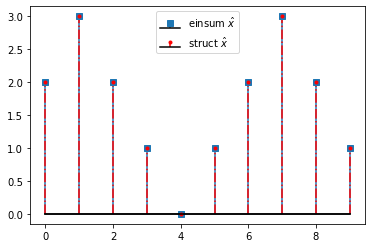

In [16]:
'''
Let's try and do something similar for the transpose now. All we have to do is slide 
UP the vector! No need to reverse the vector either. Remember to turn the list into 
a numpy array at the end!
'''

x_hat_struct = [r_long[N-1-k:2*N-1-k].dot(g_struct) for k in range(N)]
x_hat_struct = np.array(x_hat_struct) #make into numpy array

#and now we plot for comparison
plt.stem(t, x_hat_einsum, markerfmt='s', basefmt="k-")
plt.stem(t, x_hat_struct, 'r-.', markerfmt='r.', basefmt="k-")
plt.legend(('einsum $\hat{x}$', 'struct $\hat{x}$'), loc='upper center')

We got the same results, but this time around, we used much less memory.

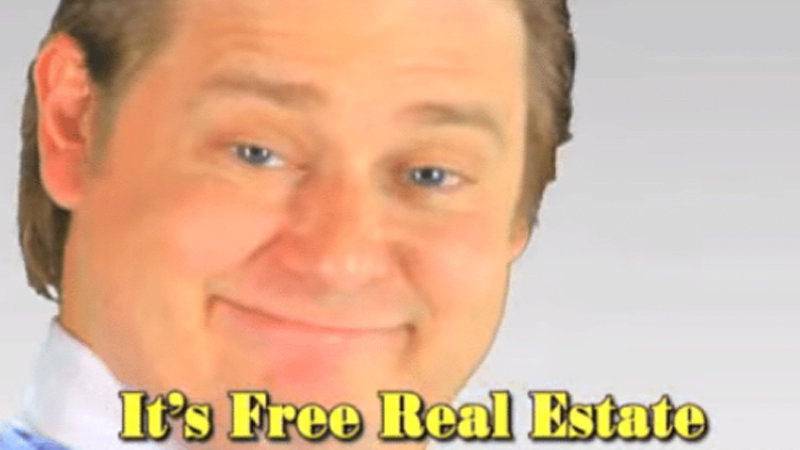

---

## Adventure time!

Now it's time for you to get your hands dirty. Check this out. Look once more at the dictionary $\boldsymbol{A}$.

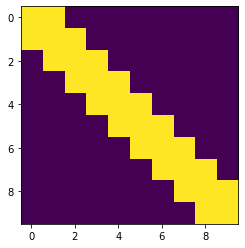

In [17]:
plt.imshow(A)

You observant cookies might have noticed that this isn't JUST a Toeplitz matrix, it's also a **symmetric matrix**.

### Task 1

How many entries of the original $N \times N$ matrix do we need to completely describe the dictionary?

### Task 2

Say the result from **Task 1** was some number $P$. Now write a code that computes $\boldsymbol{g} = \boldsymbol{Ax}$ and $\hat{\boldsymbol{x}} = \boldsymbol{A}^{\text{T}} \boldsymbol{g}$ using only those $P$ samples.

**HINT:** look at the following function. Feel free to use it if you like. Or, just come up with your own implementation for this task. Let's see what everyone ends up with!

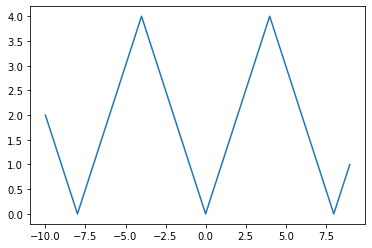

In [18]:
#fancy new function here
def tri(indices, P):
    r'''
    This function takes in a set of indices and a semi-period P and uses 
    them to return a traingle wave of period 2(P-1). How on earth is 
    this supposed to be useful? Fufufu...
    
    INPUT:
        indices: a set of indices to be used as the domain
            of our triangle wave
        P: the semi (half) -period of the triangle wave
        
    OUTPUT:
        tri: triangle wave of length len(indices) and period 2(P-1)
    '''
    
    Q = 2*(P-1) #indices only account for HALF of the triangle wave
    tri = (indices + Q/2) % Q - Q/2 #periodify every Q, swap signs every Q/2
    tri = np.abs(tri) #take absolute value so all results are positive
    return tri.astype(int) #return a triangle function offset by Q/2
    
#let's give this a test ride!
P = 5
indices = np.arange(-10,10)
triangle = tri(indices, P)
plt.plot(indices,triangle)

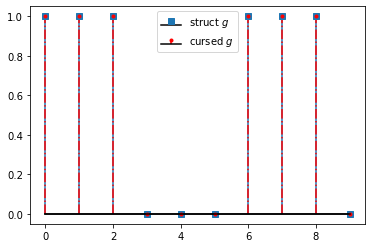

In [19]:
'''
This is my cursed implementation of a symmetric Toeplitz matrix with
only N samples. I'll delete this before distributing to the students.
'''
N = 10
T = 3
t = np.arange(0,N)
v = rect(t, T)
g_cursed = [ v[ tri(np.arange(0-k, N-k), N) ].dot(x) for k in range(N)]

plt.stem(t, g_struct, markerfmt='s', basefmt="k-")
plt.stem(t, g_cursed, 'r-.', markerfmt='r.', basefmt="k-")
plt.legend(('struct $g$', 'cursed $g$'), loc='upper center')

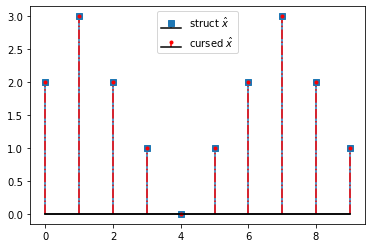

In [20]:
'''
And the transpose. Also gonna delete this for distribution. Since it's
symmetric, no changes are needed.
'''

x_hat_cursed = [ v[ tri(np.arange(0-k, N-k), N) ].dot(g_cursed) for k in range(N)]

plt.stem(t, x_hat_struct, markerfmt='s', basefmt="k-")
plt.stem(t, x_hat_cursed, 'r-.', markerfmt='r.', basefmt="k-")
plt.legend(('struct $\hat{x}$', 'cursed $\hat{x}$'), loc='upper center')

---

## 2-D Example

No tasks here for you peeps, we'll only look at an example so you can see how einsum and Toeplitz structures come into play in a more realistic scenario. Let's relax and look at some pretty pictures. 

Let's think of a dictionary again. Instead of signals or vectors $\boldsymbol{g}$, we now measure a matrix $\boldsymbol{G}\in \mathbb{R}^{N \times N}$. The previous rectangle function $\boldsymbol{r}$ is also a matrix $\boldsymbol{R} \in \mathbb{R}^{N \times N}$ now. What about the dictionary? Well, that's not a matrix anymore. The most natural description would be a *4-way array* or a *tensor* (depending on who you ask). We denote this as $\mathcal{A} \in \mathbb{R}^{N \times N \times N \times N}$. Welp. That's one huge amount of data. I won't show a representation here, though I could possibly draw something on paint the day of the presentation. One way to think of it is as an $N \times N$ matrix. Each of the elements of this matrix is... another $N \times N$ matrix. Let's say the outer matrix has rows $i$ and columns $j$, while the internal matrices have rows $k$ and columns $l$. We can refer to individual samples of $\mathcal{A}$ as $a_{i,j,k,l}$. 

You might've already realized that this is a case in which einsum would come in handy. Instead of choosing columns from a matrix by multiplying with a vector $\boldsymbol{x}$, we will now choose matrices from a tensor by multipling with a matrix $\boldsymbol{X}$. We want to describe some generic operation that looks like

$$
\boldsymbol{G} = \mathcal{A} \circledast \boldsymbol{X}
$$

and allows us to generally describe multi-way array products. The problem here is, what even IS this multiplication $\circledast$? There's a bunch of dimensions here and there, what do we do? **We** have to define this product ourselves, since it really depends on what we want do to with it. I'd say this is a situation where we can benefit from some formalism instead of trying to play around with tiles. We can say the following. Let 

$$
\boldsymbol{G} = \sum_i \sum_j \boldsymbol{R}_{i,j} x_{i,j},
$$

which tells us the resulting matrix is a sum of scaled matrices... sort of like a linear combination of matrices. We can put the matrices $\boldsymbol{R}_{i,j}$ into the tensor $\mathcal{A}$ and refer to the entries as before, $a_{i,j,k,l}$. This also allows to talk of the entries $g_{k,l}$ of the matrix $\boldsymbol{G}$. Let's plug this back into the previous expression. We get that

$$
g_{k,l} = \sum_i \sum_j a_{i,j,k,l} x_{i,j},
$$

which in Einstein notation is simply

$$
g_{k,l} = a_{i,j,k,l} x_{i,j}.
$$

Let's code this and give it a spin. **I won't explain the code, this is something for another time. Look at the pretty pictures!**

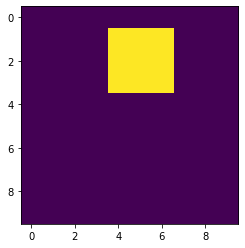

In [21]:
T = 3
N = 10
t_long = np.arange(-(N-1), N)
r_long = rect(t_long,T)
R_long = r_long.reshape(2*N-1,1).dot(r_long.reshape(1, 2*N-1))

A = [ [ R_long[ np.arange(N-1-i,2*N-1-i).reshape(N,1) , 
                np.arange(N-1-j,2*N-1-j).reshape(1,N) ] for j in range(N) ] for i in range(N) ]
A = np.array(A)

plt.imshow(A[2,5,:,:])

We get some nice little boxes that we can move around by picking indices $i,j$ from $a_{i,j,k,l}$. Let's look at another one, for good measure.

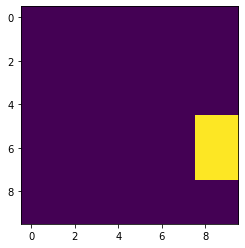

In [22]:
plt.imshow(A[6,9,:,:])

Right-o! Now, let's say we want to generate a matrix $\boldsymbol{G}$ that has a square centered at $k,l = 0,3$ with an amplitude of 5, and another centered at $k,l = 9,9$ with amplitude 3. Einsum to the rescue.

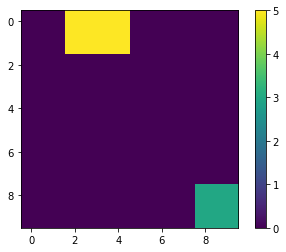

In [23]:
X = np.zeros((N,N))
X[0,3] = 5
X[9,9] = 3
G = np.einsum('ijkl,ij->kl', A, X)

plt.imshow(G)
plt.colorbar()

That's certainly pretty simple. However, consider the tensor is now of size $N^4$ and therefore needs a HUGE amount of memory. On the other hand, check out what happens when we turn the tensor into a matrix by putting all indices $i,j$ as rows and all indices $k,l$ as columns.

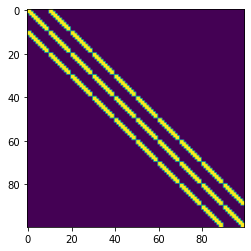

In [24]:
A_mat = A.reshape(N,N,N**2, order = 'F') #turn indices k,l into columns
A_mat = A_mat.reshape(N**2, N**2, order = 'F') #turn indices i,j into rows
plt.imshow(A_mat)

Would you look at that! That's not quite Toeplitz, is it? Indeed, this is a **block Toeplitz** matrix. The matrix is made up of many smaller matrices. The outer matrix, which contains matrices, has a Toeplitz structure. This means we only need $2N-1$ matrices to describe this block Toeplitz matrix. Furthermore, the blocks themselves are Toeplitz, so each one needs $2N-1$ samples to be describled. We end up with $(2N-1)^2$ parameters needed to describe the whole matrix with $N^4$ elements, which is a humongous memory saving. To top it off, this also happens to be symmetric at both levels. This is a **2-level symmetric block Toeplitz** matrix for which only $N^2$ samples are needed! Wooooo! To wrap all of this up, a transpose with einsum for the 2-D case.

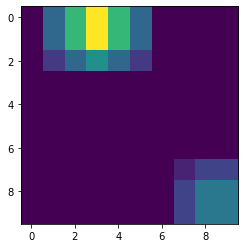

In [25]:
X_hat = np.einsum('ijkl,kl->ij', A, G)

plt.imshow(X_hat)

We also get an idea of where $\boldsymbol{X}$ was non-zero this way! Yay!